# EDA (Temporal Anomaly Detection)

In [2]:
import math
import datetime
import numpy as np
import pandas as pd

import tensorflow.keras as tfk

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## The Data

### Load the density images

In [5]:
images = np.load('density_images.npy')
images.shape

(5856, 48, 40)

### Load the mask

In [6]:
mask = np.load('density_mask.npy')
mask.shape

(48, 40)

### Extend the images

In [7]:
flat_images = images.reshape(images.shape[0], -1).astype('float32')
flat_mask   = mask.reshape(-1).astype('float32')
flat_mask.shape

(1920,)

## The Model

In [8]:
original_dim = flat_images.shape[1]
intermediate_dim = 256
latent_dim = 2

### Build the model

#### Build the encoder

In [9]:
encoder = tfk.Sequential([
    tfk.layers.Dense(512, input_shape=(original_dim,), activation='relu'),
    tfk.layers.Dense(256, activation='relu'),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dense(32, activation='relu'),
    tfk.layers.Dense(16, activation='relu'),
    tfk.layers.Dense(8, activation='relu'),
    tfk.layers.Dense(4, activation='relu'),
    tfk.layers.Dense(latent_dim)
], name="encoder")

In [10]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               983552    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136 

#### Build the decoder

In [11]:
decoder = tfk.Sequential([
    tfk.layers.Dense(8, input_shape=(latent_dim,), activation='relu'),
    tfk.layers.Dense(16, activation='relu'),
    tfk.layers.Dense(32, activation='relu'),
    tfk.layers.Dense(64, activation='relu'),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(256, activation='relu'),
    tfk.layers.Dense(512, activation='relu'),
    tfk.layers.Dense(original_dim, activation='sigmoid')
], name="decoder")

In [12]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1315

#### Build the autoencoder

In [13]:
autoencoder = tfk.Sequential([
    encoder,
    decoder
], name="autoencoder")

In [14]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 2)                 1158822   
_________________________________________________________________
decoder (Sequential)         (None, 1920)              1160712   
Total params: 2,319,534
Trainable params: 2,319,534
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [15]:
class PrintDot(tfk.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')

mask_sum = mask.sum()
    
def scaled_loss(inputs, outputs):
  outputs *= flat_mask
  loss = tfk.metrics.mean_squared_error(inputs, outputs)
  return mask_sum * loss

early_stop = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10)

autoencoder.compile(optimizer='adam', loss=scaled_loss)
history = autoencoder.fit(x=flat_images,
                          y=flat_images,
                          epochs=1000, batch_size=32,
                          validation_split=0.1, verbose=1,
                          callbacks=[early_stop]) # PrintDot(), 

Train on 5270 samples, validate on 586 samples
Epoch 1/1000
5270/5270 [==============================] - 7s 1ms/sample - loss: 21.5745 - val_loss: 5.1391
Epoch 2/1000
5270/5270 [==============================] - 7s 1ms/sample - loss: 3.7395 - val_loss: 3.1129
Epoch 3/1000
5270/5270 [==============================] - 8s 1ms/sample - loss: 2.0707 - val_loss: 1.7272
Epoch 4/1000
5270/5270 [==============================] - 8s 1ms/sample - loss: 1.6945 - val_loss: 1.6790
Epoch 5/1000
5270/5270 [==============================] - 8s 1ms/sample - loss: 1.6402 - val_loss: 1.7221
Epoch 6/1000
5270/5270 [==============================] - 7s 1ms/sample - loss: 1.6213 - val_loss: 1.6779
Epoch 7/1000
5270/5270 [==============================] - 6s 1ms/sample - loss: 1.6045 - val_loss: 1.7119
Epoch 8/1000
5270/5270 [==============================] - 7s 1ms/sample - loss: 1.5791 - val_loss: 1.6310
Epoch 9/1000
5270/5270 [==============================] - 7s 1ms/sample - loss: 1.5873 - val_loss: 1.638

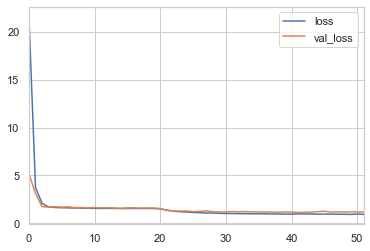

In [16]:
pd.DataFrame(history.history).plot()

### Test the model

In [17]:
y_pred = autoencoder.predict(flat_images)
tfk.metrics.mean_squared_error(flat_images, y_pred).numpy().mean()

0.07798811

In [18]:
autoencoder.evaluate(flat_images, flat_images)

5856/5856 [==============================] - 4s 660us/sample - loss: 0.9478


0.9478113012887089

### Save model

In [22]:
autoencoder.save('temporal_anomaly_detection/autoencoder.h5')

In [26]:
autoencoder_ = tfk.models.load_model('temporal_anomaly_detection/autoencoder.h5',
                                     custom_objects={'scaled_loss':scaled_loss})

### Latent space visualizations

In [33]:
latent_vars = autoencoder.get_layer('encoder')(flat_images).numpy()

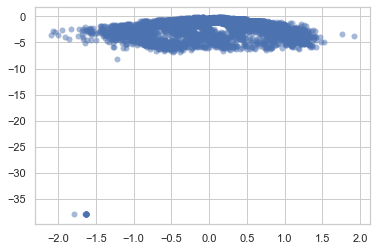

In [34]:
points = plt.scatter(latent_vars[:, 0], latent_vars[:, 1], alpha=0.5, linewidth=0)
plt.show()

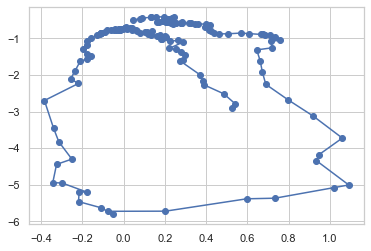

In [35]:
plt.plot(latent_vars[:4*36, 0], latent_vars[:4*36, 1], '-o')

## Calculate Mahalanobis Distances

In [38]:
train_mu = latent_vars.mean(axis=0)
train_mu = train_mu.reshape(1, -1)
print(train_mu)

[[ 0.02868951 -1.9072311 ]]


In [41]:
train_std = latent_vars.std(axis=0)
train_std = train_std.reshape(1, -1)
print(train_std)

[[0.5830229 2.27596  ]]


In [42]:
mahalanobis_dist = (((latent_vars - train_mu)/train_std)**2).sum(axis=1)**(0.5)
mahalanobis_dist.shape

(5856,)

### Save the data

In [59]:
np.save('temporal_anomaly_detection/mahalanobis_dist.npy', mahalanobis_dist)

In [50]:
np.save('temporal_anomaly_detection/train_mu.npy', train_mu)

In [51]:
np.save('temporal_anomaly_detection/train_std.npy', train_std)

### Inspect

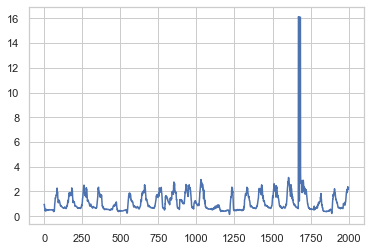

In [60]:
plt.plot(mahalanobis_dist[:2000])

(array([4778., 1057.,    9.,    0.,    0.,    0.,    0.,    0.,    0.,
          12.]),
 array([ 0.08191028,  1.686772  ,  3.2916336 ,  4.8964953 ,  6.501357  ,
         8.106219  ,  9.711081  , 11.315943  , 12.920804  , 14.525666  ,
        16.130527  ], dtype=float32),
 <a list of 10 Patch objects>)

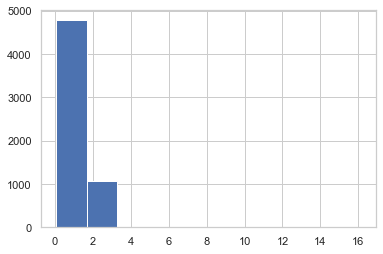

In [53]:
plt.hist(mahalanobis_dist)

In [43]:
print(mahalanobis_dist.max())
print(np.where(mahalanobis_dist == mahalanobis_dist.max()))

16.130527
(array([1670], dtype=int64),)


In [44]:
print(mahalanobis_dist.min())
print(np.where(mahalanobis_dist == mahalanobis_dist.min()))

0.08191028
(array([3906], dtype=int64),)


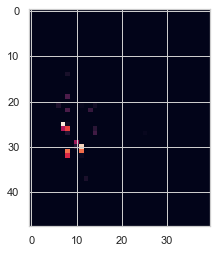

In [46]:
plt.imshow(images[1670])

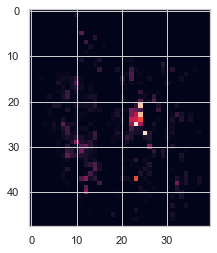

In [48]:
plt.imshow(images[3906])

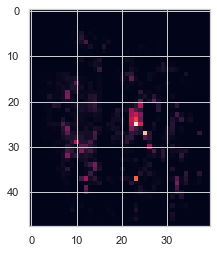

In [56]:
x_sampled = autoencoder.get_layer('decoder')(train_mu)
x_sampled = np.asarray(x_sampled)[0] * flat_mask
plt.imshow(x_sampled.reshape(48, 40))